# Map of CF Data Centers and root-servers

In [1]:
from deep_translator import GoogleTranslator
from geopy import Nominatim
from time import sleep

geolocator = Nominatim(user_agent="jupyter-city-locator-robertrichter123")

In [2]:
cf_data_centers = open('cf_data_center_locations.txt', 'r').read()
cf_dc_locations = set()
for v in cf_data_centers.replace('*', '').replace('    ', '').split('\n'):
    city = GoogleTranslator(source='de', target='en').translate(v.split(', ')[0])
    country = v.split(', ')[1]
    cf_dc_locations.add( (city, country) )

root_servers = open('root-server-locations.txt', 'r').readlines()
rs_locations = set()
for v in root_servers:
    if v == '\n': continue

    s = v.replace('\n','').split(', ')
    if len(s) < 2:
        print(s)
    rs_locations.add( (s[0], s[1]) )

## Cloudflare Data Centers

In [15]:
import requests
import json

def get_coords(city, country):
    query = city + "+" + country
    url = "https://nominatim.openstreetmap.org/search.php?q=" + query + "&format=jsonv2"
    response = requests.get(url)
    if response.status_code < 300:
        res = json.loads(response.content)
        if len(res) == 0: return False
        return res[0].get('lat'), res[0].get('lon')
    return False

cf_dc_coords = []
for (city, country) in cf_dc_locations:
    res = get_coords(city,country)
    if res:
        cf_dc_coords.append(res)

In [37]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import pandas as pd

def plot_locs(dc_coords):
    lats = [v[0] for v in dc_coords]
    long = [v[1] for v in dc_coords]
    
    data = {
        'Latitude': lats,
        'Longitude': long
    }
    
    df = pd.DataFrame(data=data)
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry)
    
    world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
    ax = world.plot(figsize=(10,6), cmap='Set2')
    ax.set_axis_off()
    gdf.plot(ax=ax, marker='o', color='black', markersize=5)

#plot_locs(cf_dc_coords)

## Root Server Locations

In [36]:
rs_coords = []
for (city, country) in rs_locations:
    res = get_coords(city,country)
    if res:
        rs_coords.append(res)

NameError: name 'plot_locs' is not defined

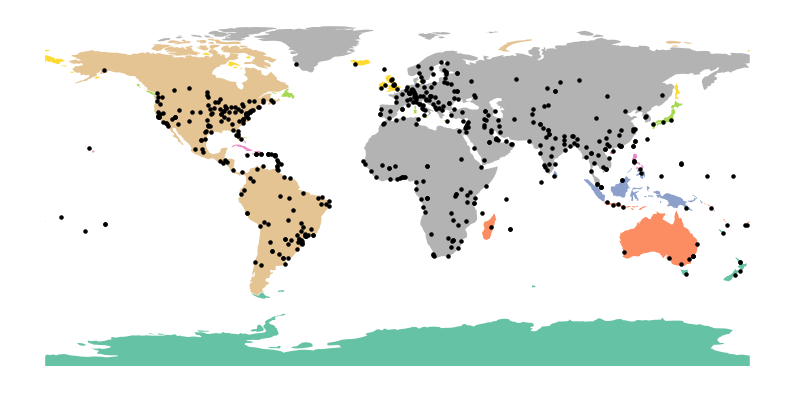

In [38]:
plot_locs(rs_coords)